In [16]:
from pathlib import Path

import cv2
import numpy as np
from loguru import logger
from tqdm import tqdm
import matplotlib.pyplot as plt


def find_chessboard_corners(image_path, chessboard_size):
    image = cv2.imread(str(image_path))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_image, chessboard_size, None)
    return ret, corners, gray_image, image


def save_stereo_maps(file_name, stereo_map_l, stereo_map_r):
    cv2_file = cv2.FileStorage(file_name, cv2.FILE_STORAGE_WRITE)
    cv2_file.write('stereoMapL_x', stereo_map_l[0])
    cv2_file.write('stereoMapL_y', stereo_map_l[1])
    cv2_file.write('stereoMapR_x', stereo_map_r[0])
    cv2_file.write('stereoMapR_y', stereo_map_r[1])
    cv2_file.release()


def calculate_reprojection_error(objpoints, imgpoints, camera_matrix, dist_coeffs, rvecs, tvecs):
    total_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(
            objpoints[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
        error = cv2.norm(imgpoints[i], imgpoints2,
                         cv2.NORM_L2) / len(imgpoints2)
        total_error += error
    mean_error = total_error / len(objpoints)
    return mean_error


In [17]:
#checked
ret, corners, gray_image, image = find_chessboard_corners("synched/img_cam0_00.png", (4, 4))

print(corners.shape)
print(image.shape)

(16, 1, 2)
(480, 640, 3)


In [64]:
def calculate_stereo_reprojection_error(objpoints, imgpoints_l, imgpoints_r, camera_matrix_l, dist_l, camera_matrix_r, dist_r, rot, trans):
    """
        NOTE:
        - This function assumes that 'rot' and 'trans' are the rotation and translation matrices
          describing the transformation from the left to the right camera.
        - The function uses the first set of image points to determine the image size for stereo rectification,
          so it's important that all image points are consistent in size.
        - This approach provides a more comprehensive measurement of the stereo system's accuracy, taking into
          account the relative positions and orientations of the two cameras.
    """
    total_error = 0

    height, width = 480, 640
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        camera_matrix_l, dist_l, camera_matrix_r, dist_r, (width, height), rot, trans)


    for i in range(len(objpoints)):
        # Undistort points
        undistorted_points_l = cv2.undistortPoints(
            imgpoints_l[i], camera_matrix_l, dist_l, P=P1)
        undistorted_points_r = cv2.undistortPoints(
            imgpoints_r[i], camera_matrix_r, dist_r, P=P2)

        # Triangulate points in 3D space
        points_4d = cv2.triangulatePoints(
            P1, P2, undistorted_points_l, undistorted_points_r)
        points_3d = points_4d / np.tile(points_4d[-1, :], (4, 1))

        # Reproject points back to 2D
        reprojected_points_l, _ = cv2.projectPoints(
            points_3d[:3].T, R1, trans, camera_matrix_l, dist_l)
        reprojected_points_r, _ = cv2.projectPoints(
            points_3d[:3].T, R2, -trans, camera_matrix_r, dist_r)
        # Calculate error
        error_l = cv2.norm(
            imgpoints_l[i], reprojected_points_l, cv2.NORM_L2) / len(reprojected_points_l)
        error_r = cv2.norm(
            imgpoints_r[i], reprojected_points_r, cv2.NORM_L2) / len(reprojected_points_r)
        total_error += (error_l + error_r) / 2

    mean_error = total_error / len(objpoints)  # Calculate the mean error
    return mean_error

In [123]:
# Parameters
chessboard_size = (5, 7) # rows, columns
frame_size = (640, 480)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
size_of_chessboard_squares_mm = 40

# Prepare object points
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]
                       ].T.reshape(-1, 2) * size_of_chessboard_squares_mm

objpoints = []
imgpoints_l = []
imgpoints_r = []

# Define the paths
synched_dir = Path.cwd() / 'synched'
images_left = sorted(synched_dir.glob('img_cam0_*.png'))
images_right = sorted(synched_dir.glob('img_cam1_*.png'))

#counter = 0
progress_bar = tqdm(total=len(images_left), desc='Finding Corners')
for img_left, img_right in zip(images_left, images_right):
    ret_l, corners_l, gray_l, img_l = find_chessboard_corners(
        img_left, chessboard_size)
    ret_r, corners_r, gray_r, img_r = find_chessboard_corners(
        img_right, chessboard_size)

    if ret_l and ret_r:
        #counter += 1
        objpoints.append(objp)
        corners_l = cv2.cornerSubPix(
            gray_l, corners_l, (11, 11), (-1, -1), criteria)
        imgpoints_l.append(corners_l)
        corners_r = cv2.cornerSubPix(
            gray_r, corners_r, (11, 11), (-1, -1), criteria)
        imgpoints_r.append(corners_r)

        cv2.drawChessboardCorners(img_l, chessboard_size, corners_l, ret_l)
        cv2.drawChessboardCorners(img_r, chessboard_size, corners_r, ret_r)
        cv2.imshow('img left', img_l)
        cv2.imshow('img right', img_r)
        cv2.waitKey(5000)
    # else:
    #     print(f"ret_l:{ret_l}   ret_r:{ret_r}  {str(img_left)[-15:]}, {str(img_right)[-15:]}")
    
    # Update the progress after each iteration
    progress_bar.update(1)  # TODO: Fix the extra progress bar issue

cv2.destroyAllWindows()

# Close the progress bar after the loop
progress_bar.close()

# Calibrate cameras
ret_l, camera_matrix_l, dist_l, rvecs_l, tvecs_l = cv2.calibrateCamera(
    objpoints, imgpoints_l, frame_size, None, None)
ret_r, camera_matrix_r, dist_r, rvecs_r, tvecs_r = cv2.calibrateCamera(
    objpoints, imgpoints_r, frame_size, None, None)

# Calculate reprojection errors
error_l = calculate_reprojection_error(
    objpoints, imgpoints_l, camera_matrix_l, dist_l, rvecs_l, tvecs_l)
error_r = calculate_reprojection_error(
    objpoints, imgpoints_r, camera_matrix_r, dist_r, rvecs_r, tvecs_r)
logger.info(f"Left_Camera Reprojection Error: {error_l}")
logger.info(f"Right_Camera Reprojection Error: {error_r}")

# Stereo Calibration
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
criteria_stereo = (cv2.TERM_CRITERIA_EPS +
                   cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-6)
ret_stereo, new_camera_matrix_l, dist_l, new_camera_matrix_r, dist_r, rot, trans, essential_matrix, fundamental_matrix = cv2.stereoCalibrate(
    objpoints, imgpoints_l, imgpoints_r, camera_matrix_l, dist_l, camera_matrix_r, dist_r, gray_l.shape[::-1], criteria_stereo, flags)


# Stereo Rectification
rectify_scale = 1
rect_l, rect_r, proj_matrix_l, proj_matrix_r, Q, roi_l, roi_r = cv2.stereoRectify(
    new_camera_matrix_l, dist_l, new_camera_matrix_r, dist_r, gray_l.shape[::-1], rot, trans, rectify_scale)

# Comment explaining the unused variables
# NOTE: Essential matrix, fundamental matrix, Q matrix, roi_l, and roi_r are computed as part of the stereo calibration
# and rectification process. These are not used in the current reprojection error calculation but are valuable for
# advanced stereo vision applications like 3D reconstruction, feature matching, and depth estimation.

# Undistort and Rectify Maps
stereo_map_l = cv2.initUndistortRectifyMap(
    new_camera_matrix_l, dist_l, rect_l, proj_matrix_l, gray_l.shape[::-1], cv2.CV_16SC2)
stereo_map_r = cv2.initUndistortRectifyMap(
    new_camera_matrix_r, dist_r, rect_r, proj_matrix_r, gray_r.shape[::-1], cv2.CV_16SC2)

# Calculate stereo reprojection error
stereo_error = calculate_stereo_reprojection_error(
    objpoints, imgpoints_l, imgpoints_r, camera_matrix_l, dist_l, camera_matrix_r, dist_r, rot, trans)

logger.info(f"Stereo Reprojection Error: {stereo_error}")
logger.info(f"ret_stereo: {ret_stereo}")

# Save Stereo Maps
save_stereo_maps('stereo_map.xml', stereo_map_l, stereo_map_r)
logger.info("Stereo maps saved.")

Finding Corners: 100%|██████████████████████████| 20/20 [01:29<00:00,  4.49s/it]
2023-12-13 07:38:32.045 | INFO     | __main__:<module>:66 - Left_Camera Reprojection Error: 0.03624415540481985
2023-12-13 07:38:32.046 | INFO     | __main__:<module>:67 - Right_Camera Reprojection Error: 0.03883785684332502
2023-12-13 07:38:32.193 | INFO     | __main__:<module>:98 - Stereo Reprojection Error: (2544.5722914547277, 860.2077289809176, 4552.56353374187)
2023-12-13 07:38:32.194 | INFO     | __main__:<module>:99 - ret_stereo: 0.6596195767022319
2023-12-13 07:38:32.371 | INFO     | __main__:<module>:103 - Stereo maps saved.


In [47]:
# 9 images lost!
print(counter, '/31 paired images are available!')
print('objpoints_shape: ', np.array(objpoints).shape)
print('objpoint_shape: ',objp.shape)

22 /31 paired images are available!
objpoints_shape:  (22, 16, 3)
objpoint_shape:  (16, 3)


In [41]:
# (640, 480) -> (480, 640)
print(img_l.shape)
print(img_r.shape)

(480, 640, 3)
(480, 640, 3)


In [53]:
print(corners_l.shape)
# list of corners_l
np.array(imgpoints_l).shape

(16, 1, 2)


(22, 16, 1, 2)

In [59]:
imgpoints_l[0].shape[:2]

(16, 1)

In [66]:
gray_l.shape[::-1]

(640, 480)

In [71]:
ret_stereo

39.43620404978738

In [79]:
# ret_stereo, new_camera_matrix_l, dist_l, new_camera_matrix_r, dist_r, rot, trans, essential_matrix, fundamental_matrix = cv2.stereoCalibrate(
#     objpoints, imgpoints_l, imgpoints_r, camera_matrix_l, dist_l, camera_matrix_r, dist_r, gray_l.shape[::-1], criteria_stereo, flags)

In [80]:
trans

array([[-352.37356833],
       [  57.25650455],
       [ 141.01245041]])

In [81]:
rot

array([[ 0.6578352 ,  0.18356676,  0.73044924],
       [-0.10194936,  0.98262034, -0.15512447],
       [-0.74622998,  0.0275775 ,  0.66511676]])

In [103]:
imgpoints_l[0][0][0][1]

86.76137

In [86]:
imgpoints_r[0]

array([[[203.66415 ,  96.473564]],

       [[281.62772 ,  96.514984]],

       [[360.12988 ,  97.026146]],

       [[438.55078 ,  98.18256 ]],

       [[204.27023 , 174.93236 ]],

       [[281.48236 , 174.90352 ]],

       [[359.32193 , 175.52834 ]],

       [[437.04526 , 176.30492 ]],

       [[205.08438 , 251.7291  ]],

       [[281.26807 , 251.98378 ]],

       [[358.3468  , 252.68486 ]],

       [[435.5352  , 253.4552  ]],

       [[206.42749 , 327.1635  ]],

       [[281.57578 , 327.66208 ]],

       [[357.64038 , 329.04822 ]],

       [[433.66138 , 329.56854 ]]], dtype=float32)

In [88]:
import matplotlib.pyplot as plt

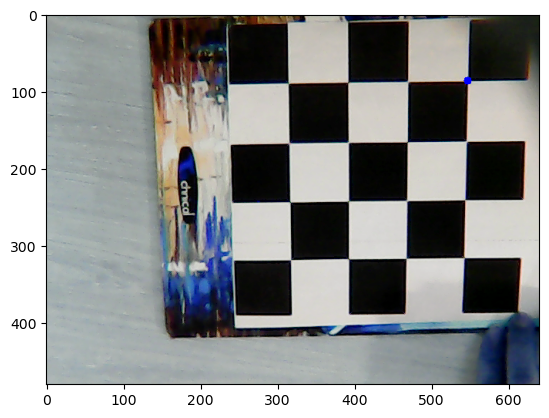

In [95]:
i = 2

img = cv2.imread('synched/img_cam0_00.png')
cv2.circle(img, (547, 86), 5, (0, 0, 255), -1)
plt.imshow(img)

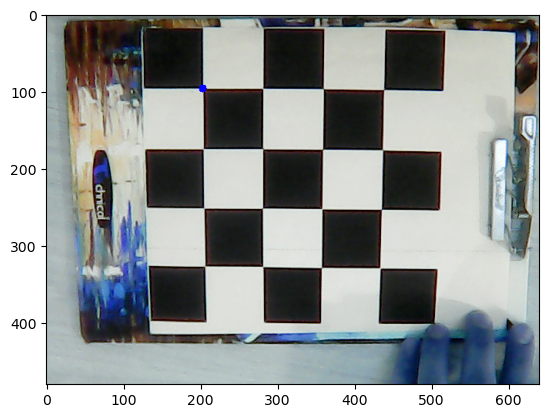

In [97]:
img = cv2.imread('synched/img_cam1_00.png')
cv2.circle(img, (int(imgpoints_r[0][0][0][0]), int(imgpoints_r[0][0][0][1])), 5, (0, 0, 255), -1)
plt.imshow(img)

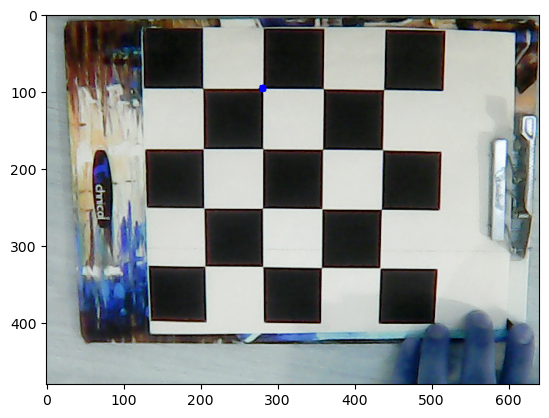

In [114]:
i = 1
img = cv2.imread('synched/img_cam1_00.png')
cv2.circle(img, (int(imgpoints_r[0][i][0][0]), int(imgpoints_r[0][i][0][1])), 5, (0, 0, 255), -1)
plt.imshow(img)


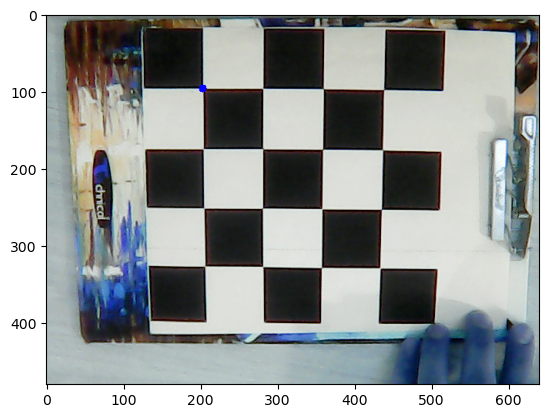

In [119]:
i = 0
img = cv2.imread('synched/img_cam1_00.png')
cv2.circle(img, (int(imgpoints_r[0][i][0][0]), int(imgpoints_r[0][i][0][1])), 5, (0, 0, 255), -1)
plt.imshow(img)

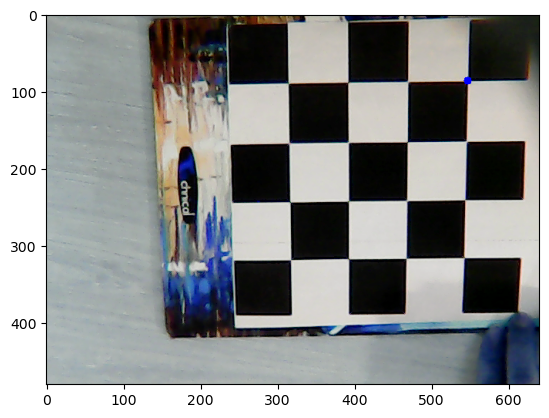

In [120]:
i = 0
img = cv2.imread('synched/img_cam0_00.png')
cv2.circle(img, (int(imgpoints_l[0][i][0][0]), int(imgpoints_l[0][i][0][1])), 5, (0, 0, 255), -1)
plt.imshow(img)